In [1]:
%run ralstats.py

Welcome to JupyROOT 6.24/01


# RAL Hands-on "Statistical Analysis Lab" Session

In this session you will learn how to perform the most common statistical analysis tasks, building things up from two fundamental operations: *fitting* and *generating*.

### Learning Objectives

In this session we will go cover the operations involved in the calculation of:

    1. Exclusion Limits
    2. Discovery p-values
    3. Parameter estimation and impact calculation

In your real work it is likely that you will utilise one of the many "statistical toolkits" that have been developed that will automate the calculation and visualization of these analyses for you. The objective of this session is to give you the **confidence that you understand what the toolkits *should* be doing** under the hood, and know how to interrogate the calculations they are making by **asking sensible questions** of those toolkits. This is an important skill because there are lots of ways in which these analyses can go wrong, and so **understanding what the calculations are doing is essential for enabling you to effectively debug problems.**

The tutorial uses the RooFit statistical modelling toolkit, but minimal experience of the classes of this toolkit are required.

### Basic functions

The following functions are provided for you in this session:

| function | arguments | description |
|----------|-----------|---------------|
| `getWorkspace(day,month)` | `day`: Your birthday day of month (1-31)<br>`month`: Your birthday month of year (1-12) | Returns a `RooWorkspace` containing the model and data you will use |
| `plot(model,dataset,globs)` | `model`: the model (a `RooAbsPdf`)<br>`dataset`: the dataset (a `RooDataSet`)<br>`globs`: the global observable values of the dataset (a `RooArgSet`) | A visualization of the model and dataset, taking into account the current values of the parameters of the model. It shows one plot for each channel of the model, and a plot for each global observable overlaying its corresponding probability distribution in the model. |
| `fit(model,dataset,globs)` | As above | Returns a `RooFitResult` from fitting the model to the data. The floating parameters of the model are the ones that are not marked constant at the time the function is called.
| `generate(model, fitResult=None, expected=False)` | `model`: As above<br>`fitResult`: The `RooFitResult` used to set all the parameters of the model to before generating<br>`expected`: if `True` will return the asimov dataset rather than a random toy | Returns a `RooDataSet` and a `RooArgSet` of the dataset and globs. Note: if no fit result is passed, the current values of the parameters are used. |

## Getting to know our model

There unfortunately isn't time in this session to teach you about building models. So we provide you one instead. Access it with the `getWorkspace` function and lets familiarize ourself with it:

In [2]:
w = getWorkspace(18,6)

[#1] INFO:ObjectHandling -- RooWorkspace::import(combined) importing dataset obsData


<span style="color:orange">**Task: Access the model (called "simPdf"), dataset (called "obsData"), and global observables (snapshot called "obsGlobs") from the workspace ...**</span>

In [3]:
model = w.pdf("simPdf")
obsData = w.data("obsData")
obsGlobs = w.getSnapshot("obsGlobs")

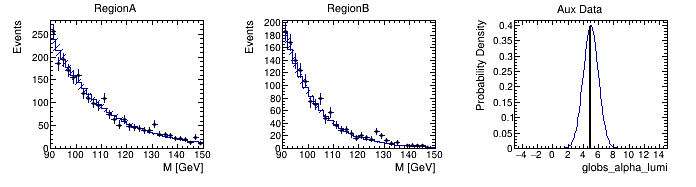

In [4]:
plot(model,obsData,obsGlobs)

Discussion: What are we seeing?

<span style="color:orange">**Task: Access the variables of the model and understand what they represent by changing their values and replotting the model. Generate some toy datasets and visualize them too, and try running a fit...**</span>

In [5]:
model.getVariables().Print("v")


  1) 0x5587eec2f9a0 RooRealVar::                1 = 1 C  L(-INF - +INF)  "1"
  2) 0x5587f0158060 RooRealVar::       alpha_lumi = 5 +/- 1  L(0 - 100)  "alpha_lumi"
  3) 0x5587ef440330 RooCategory::       channelCat = RegionA(idx = 0)
  "channelCat"
  4) 0x5587f067a330 RooRealVar:: globs_alpha_lumi = 14.9 C  L(-5 - 15)  "globs_alpha_lumi"
  5) 0x5587ee85c020 RooRealVar::            m_obs = 149  L(90 - 150) B(30)  "M [GeV]"
  6) 0x5587f08923a0 RooRealVar::               mu = 0  L(0 - 100)  "mu"
  7) 0x5587f052fef0 RooRealVar::         sig_mass = 110 C  L(-INF - +INF)  "sig_mass"
  8) 0x5587f052fa30 RooRealVar::        sig_width = 2 C  L(-INF - +INF)  "sig_width"


<span style="color:orange">**Task: Assign the variables representing signal mass and signal strength to the python variables below...**</span>

In [6]:
mass_var = model.getVariables()["sig_mass"]
mu_var = model.getVariables()["mu"]

## Hypothesis Testing: Exclusions and Discovery

Exclusions and Discovery plots are just a way of presenting the results of a collection of Hypothesis Tests. A Hypothesis Test is really the process of calculating a p-value and seeing whether its less than or greater than a  critical value (0.05 in the case of 95% CL). The procedure for making these plots is as follows:

  1. Define a `Hypothesis Space`, which involves deciding which parameters of the BSM model we want to scan over.
      (elsewhere people call this a *parameter grid*):
  2. Choose a `Test Statistic` to perform hypothesis tests with, the normal choice is:
      * Exclusions: One-sided-positive Profile Likelihood Ratio Test Statistic $q_\mu$
      * Discovery: One-sided-negative Profile Likelihood Ratio Test Statistic $q_0$
  3. Choose a definition of `P Value` to use, there are three types:
      * null p-value: The p-value under the null hypothesis (the hypothesis being tested)
         * In exclusion tests the null hypothsesis is a particular s+b hypothesis, and null p-value is sometimes then called the CLs+b p-value.
         * In discovery tests the null hypothesis is the bkg-only hypothesis, and the null p-value is sometimes called the $p_0$ p-value.
      * alt p-value: The p-value under an alternative hypothesis (only relevant for exclusions), also calld the CLb p-value
      * CLs p-value: The ratio of the above two p-values
  4. Find the contour of `Hypothesis Points` in your `Hypothesis Space` where your chosen p-value equals the critical value (0.05 for a 95% confidence limit). This is usually done by selecting a grid of points in the space and computing the p-value for each (aka doing a hypothesis test), then interpolating between them to give you a contour. 
  5. `Expected` contours can also be computed by throwing toys from the expected hypothesis and computing the median p-value of these toys at each hypothesis point. The contour is drawn as before by interpolating these median p-values across the space. 1 sigma and 2 sigma "bands" can be computed by examining a different p-value than the median one, as we will discuss later.
      * Note that the expected contour is often instead estimated by using the *Asimov Dataset* which corresponds to the expected data under the alternative hypothesis. This is not quite the same as using toys but usually gives a very similar result.

### 1. The Hypothesis Space

Our hypothesis space will span signal mass in the x-axis, and signal strength in the y-axis. We will leave signal width fixed. Note that you don't have to choose signal strength as one of your space axis parameters, SUSY analyses for example often scan over a pair of masses and leave signal strength fixed to 1. 

We'll use a `TGraph` to keep track of which points we are running hypothesis tests for

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


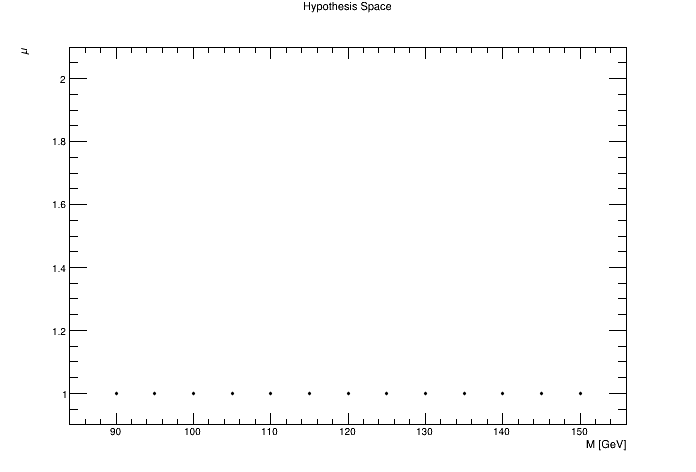

In [7]:
hypoSpace = ROOT.TGraph()
hypoSpace.SetTitle("Hypothesis Space;M [GeV];\mu")

# start with just some points @ mu=1
mass_var.setVal(90.0)
mu_var.setVal(1.0)

while mass_var.getVal()<=150.0:
    hypoSpace.AddPoint(mass_var.getVal(),mu_var.getVal())
    mass_var.setVal(mass_var.getVal()+5.0)

myPlot = ROOT.gROOT.MakeDefCanvas()
hypoSpace.Draw("AP")
myPlot.Draw()

### 2. The Test Statistic 

The test statistics we are using today are all based on the *(two-sided) profile likelihood ratio*, $t_\mu$:

$$
t_\mu = -2log\left( \frac{L(\mu,\hat{\hat{\theta}})}{L(\hat{\mu},\hat{\theta})}\right)
$$

The test statistic we will use for limits is the *one-sided capped-above profile likelihood ratio* , $q_\mu$:

$$
q_\mu = \begin{cases}
    t_\mu \text{ if $\hat\mu < \mu$,} \\
    0 \text{ if $\hat\mu >= \mu$}.
    \end{cases}
$$

The test statistic we will use discovery is the *one-sided capped-below profile likelihood ratio*, $q_0$:

$$
q_0 = \begin{cases}
    t_\mu \text{ if $\hat\mu > 0$,} \\
    0 \text{ if $\hat\mu <= 0$}.
    \end{cases}
$$

<span style="color:orange">**Task: Implement a function that can calculate any of these profile likelihood test statistics ...**</span>

In [8]:
def pll(mu_test, data, globs, oneSided=False, cappedAbove=True):
    mu_var.setConstant(False)
    ufit = fit(model,data,globs)
    if ufit.status()!=0:
        print("Unconditional fit failed",ufit.status())
        return None
    if oneSided:
        if cappedAbove and ufit.floatParsFinal().find(mu_var.GetName()).getVal() >= mu_test: return 0
        if not cappedAbove and ufit.floatParsFinal().find(mu_var.GetName()).getVal() <= mu_test: return 0
    mu_var.setVal(mu_test)
    mu_var.setConstant(True)
    cfit = fit(model,data,globs)
    if cfit.status()!=0:
        print("Conditional fit failed",cfit.status())
        return None
    return 2.*(cfit.minNll() - ufit.minNll())

Now we use your function to evaluate the test statistic with the observed data at $\mu=1$ at different values of signal mass.

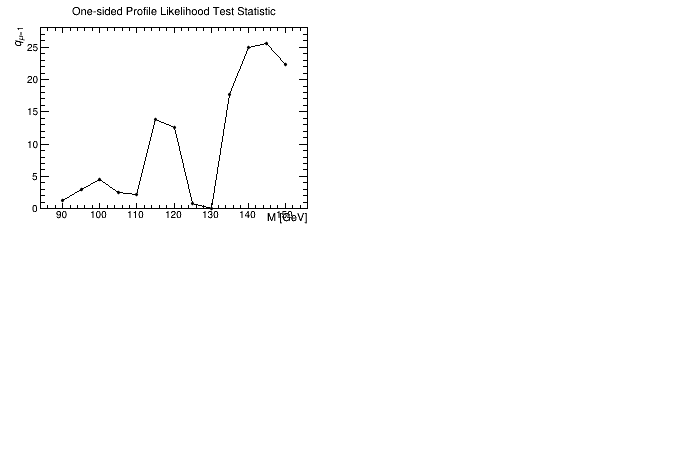

In [9]:
import numpy as np
c = ROOT.TCanvas()
c.DivideSquare(4)

obs_plls = ROOT.TGraph()
obs_plls.SetTitle("One-sided Profile Likelihood Test Statistic;M [GeV];\\tilde{q}_{\mu=1}")

for i in range(hypoSpace.GetN()):
    mass_var.setVal(hypoSpace.GetPointX(i))
    obs_pll = pll(hypoSpace.GetPointY(i),obsData,obsGlobs,True)
    obs_plls.AddPoint(mass_var.getVal(),obs_pll)
    
c.SetSelectedPad( c.GetPad(1).cd() )
obs_plls.DrawClone("ALP")
c.Draw()

Questions:
   * What is the meaning of this test statistic value? What does a small or big value mean?
   * Why this test statistic for hypothesis testing?

### 3. The P-Value

Now, this is the computationally difficult bit. We need to know the p-value of our observed test statistic values. For the CLs+b p-value this is the fraction of toys generated under the null hypothesis that had a test statistic value greater than the one we observed. The CLb is similar but with toys generated under the alternative hypothesis. 

<span style="color:orange">**Task: Implement a function that can generate the test statistic distribution from toys and use it to estimate the p-value ...**</span>

 98%|█████████▊| 985/1000 [01:41<00:01,  8.81it/s]

Unconditional fit failed -1


100%|██████████| 1000/1000 [01:43<00:00,  8.79it/s]
Warning in <TLegend::Paint>: Legend too large to be automatically placed; a default position is used


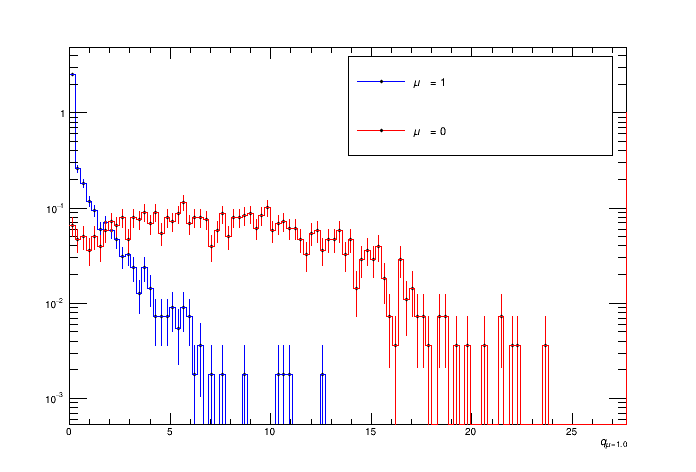

In [10]:
def pvalue(nToys, mu_true, obs_ts):
    mu_test = mu_var.getVal()
    hist = ROOT.TH1D("toys","\mu' = {};q_{{\mu={}}}".format(mu_true,mu_test),100,0,2*obs_ts)
    hist.SetDirectory(0)
    
    mu_var.setVal(mu_true)
    mu_var.setConstant()
    true_fit = fit(model,obsData,obsGlobs)
        
    nUp = 0
    for i in tqdm.tqdm(range(nToys)):
        mu_var.setVal(mu_test)
        toy_ts = pll(mu_test,*generate(model,true_fit),True)
        if toy_ts is None: continue # should really handle bad fits
        nUp += (toy_ts >= obs_ts)
        hist.Fill(toy_ts)
    
    # convert hist into a PDF by normalizing and dividing by bin width
    hist.Scale(1./(nToys*hist.GetBinWidth(1)))
    
    # leave mu at its original value
    mu_var.setVal(mu_test)
    
    return nUp/nToys , hist 

mu_var.setVal(hypoSpace.GetPointY(5))
mass_var.setVal(hypoSpace.GetPointX(5))
pval_clsb, nullHist = pvalue(2000,1,obs_plls.GetPointY(5))
pval_clb, altHist = pvalue(1000,0,obs_plls.GetPointY(5))

nullHist.SetLineColor(ROOT.kBlue);altHist.SetLineColor(ROOT.kRed)
myPlot.cd(); myPlot.SetLogy()
nullHist.DrawClone("histe");altHist.DrawClone("histe same")
myPlot.BuildLegend()
l = ROOT.TLine();l.SetLineWidth(2);l.DrawLine(obs_plls.GetPointY(5),0,obs_plls.GetPointY(5),1) # obs ts value
myPlot.Draw()

Questions:

  * Why do the alt hypothesis toys take longer to run than the null hypothesis toys?
     ans: alt toys more frequently need the conditional fit as well as the unconditional fit
  * How would we extract the expected p-value from this plot?
  * Should p-values have an uncertainty?

### A shortcut to p-values: Asymptotic formulae



In [11]:
help(asymptotic_pvalue_qmu)

Help on function asymptotic_pvalue_qmu in module __main__:

asymptotic_pvalue_qmu(qmu, mu, mu_prime, sigma_mu, mu_min=-inf, mu_max=inf)
    qmu : the one-sided-positive test statistic value 
    mu : the null hypothesis mu value
    mu_prime : the true hypothesis mu value ( = mu for null hypothesis )
    sigma_mu : stdev of mu_hat under the true hypothesis (estimate as |mu - mu_prime|/sqrt(tmu(asimov_mu_prime)))
    mu_min : min value of mu
    mu_max : max value of mu



<span style="color:orange">**Task: Write a function to fill a graph with the PDF of the asymptotic p-value. Use it to explore the shape of the function for different values of $\sigma_{\hat{\mu}}$ and $\mu$ ...**</span>

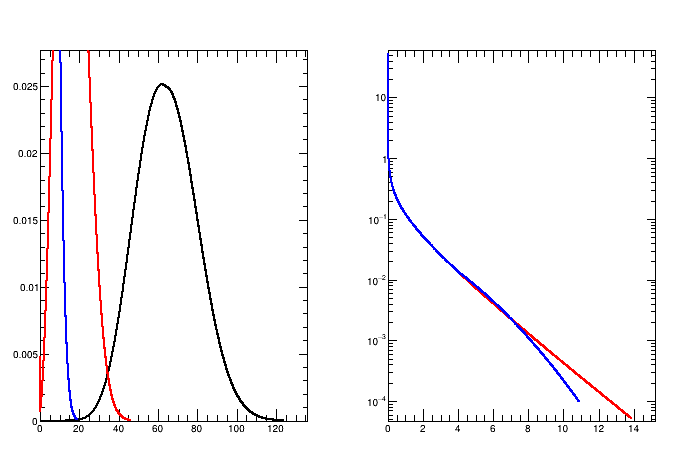

In [21]:
def asymptotic_graph(mu_test, mu_prime, sigma_mu):
    out = ROOT.TGraph(); out.SetLineWidth(2)
    pval = 1
    qmu = 0
    step = 0.01
    while pval > 0.0001:
        next_pval = asymptotic_pvalue_qmu(qmu+step, mu_test, mu_prime, sigma_mu, 0)
        out.AddPoint(qmu+0.5*step, (pval-next_pval)/step)
        pval = next_pval
        qmu += step
    return out
    
myPlot.cd()
myPlot.Clear()
myPlot.Divide(2,1)
myPlot.cd(1)
asymptotic_graph(4,0,0.5).DrawClone("AL")
asymptotic_graph(4,0,1).DrawClone("L").SetLineColor(ROOT.kRed)
asymptotic_graph(4,0,2).DrawClone("L").SetLineColor(ROOT.kBlue)
myPlot.cd(2).SetLogy()
asymptotic_graph(4,4,0.5).DrawClone("AL")
asymptotic_graph(4,4,1).DrawClone("L").SetLineColor(ROOT.kRed)
asymptotic_graph(4,4,2).DrawClone("L").SetLineColor(ROOT.kBlue)
myPlot.Draw()

Questions:
  * How does the asymptotic distribution depend on $\sigma_{\hat{\mu}}$ parameter?
  * What happens when plotting the null hypothesis distribution for $\mu=0$? Why? Ans: it's a delta function @ 0 because all mu_hat are > 0 so qmu is always 0

To use the asymptotic formulae we will need to estimate $\sigma_{\hat{\mu}}$, which we can do with the asimov dataset (the expected dataset) and using the formula:
$$
\sigma_{\hat{\mu}}\approx\frac{\mu - \mu'}{\sqrt{t_\mu( D_{exp}(\mu') )}}
$$

where $\mu$ is the hypothesis being tested, $\mu'$ is the 'true' hypothesis, $t_\mu(...)$ is the regular (two-sided) profile likelihood ratio, and $D_{exp}(\mu')$ is the asimov dataset under the $\mu'$ hypothesis.

Task: Write code to estimate $\sigma_{\hat{\mu}}$ for the hypothesis points in our hypothesis space:

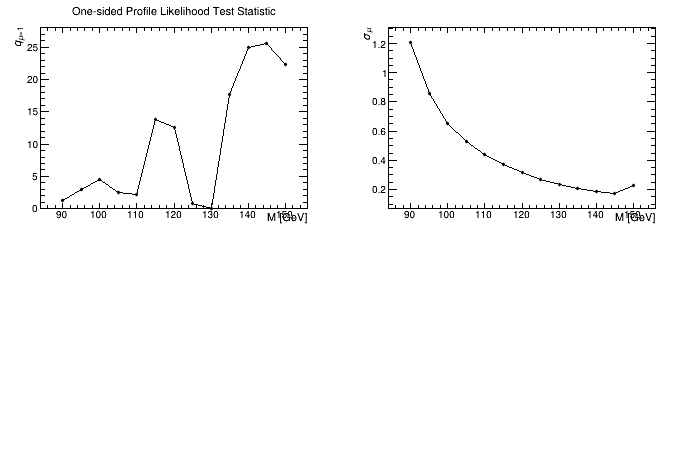

In [22]:
sigma_mus = ROOT.TGraph()
sigma_mus.SetTitle("std deviation of \hat{\mu};M [GeV];\sigma_{\mu}")

# can do this here because cfit for all signals will be same for mu=0
mu_alt = 0
mu_var.setVal(mu_alt); mu_var.setConstant(True)
cfit = fit(model,obsData,obsGlobs)
asimovData = generate(model,cfit,True)

import math
for i in range(hypoSpace.GetN()):
    mass_var.setVal(hypoSpace.GetPointX(i))
    asimov_pll = pll(hypoSpace.GetPointY(i),*asimovData,False)
    sigma_mu = (mu_var.getVal()-mu_alt)/math.sqrt( asimov_pll )
    sigma_mus.AddPoint(hypoSpace.GetPointX(i),sigma_mu)
    
c.cd(2)
sigma_mus.Draw("ALP")
c.Draw()

Now that we have computed $\sigma_{\hat{\mu}}$ values, plot the asymptotic function on top of the toy distributions to see assess if for this particular hypothesis we are in the "asymptotic regime" ...

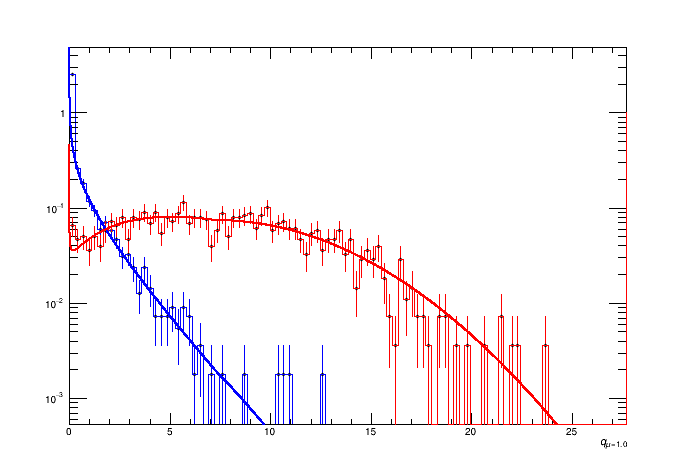

In [23]:
nullGr = asymptotic_graph(1,1,sigma_mus.GetPointY(5))
altGr = asymptotic_graph(1,0,sigma_mus.GetPointY(5))
nullGr.SetLineColor(nullHist.GetLineColor())
altGr.SetLineColor(altHist.GetLineColor())

myPlot.cd()
nullHist.DrawClone("histe");altHist.DrawClone("histe same")
nullGr.Draw("L"); altGr.Draw("L")
myPlot.Draw()

<span style="color:orange">**Task: Now use the asymptotic formulae functions to graph the asymptotic CLs p-value:**</span>

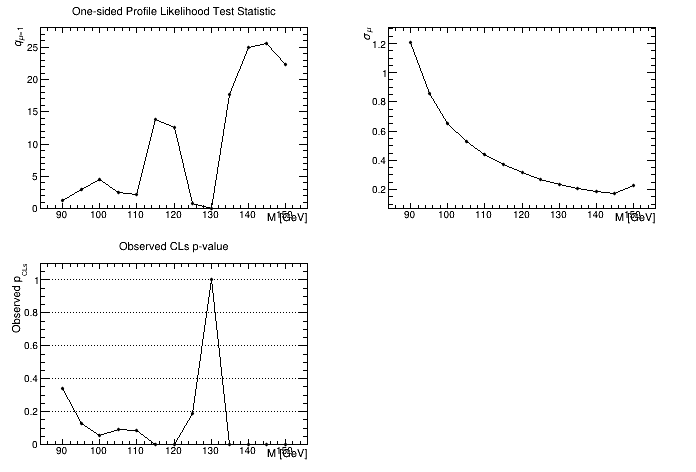

In [24]:
obs_pvals = ROOT.TGraph()
obs_pvals.SetTitle("Observed CLs p-value;M [GeV];Observed p_{CLs}")

for i in range(hypoSpace.GetN()):
    psb = asymptotic_pvalue_qmu(obs_plls.GetPointY(i), hypoSpace.GetPointY(i), hypoSpace.GetPointY(i), sigma_mus.GetPointY(i), 0)
    pb = asymptotic_pvalue_qmu(obs_plls.GetPointY(i), hypoSpace.GetPointY(i), 0, sigma_mus.GetPointY(i), 0)
    obs_pvals.AddPoint(hypoSpace.GetPointX(i),psb/pb)
    
c.cd(3)
obs_pvals.Draw("ALP")
ROOT.gPad.SetGridy()
c.Draw()

## 4. Finding the P-Value Contours

Now that we have a quick way to estimate p-values, our objective is to find the contour of hypothesis points in a full hypothesis where the p-value equals the critical value. 

Question: For a 95% CL limit, what is the critical value?

<span style="color:orange">**Task: Define a full 2D hypothesis space, scanning mu values from 0.2 to 2 in steps of 0.2, and mass values from 90-150 in steps of 5 GeV:**</span>

In [25]:
fullHypoSpace = ROOT.TGraph()
fullHypoSpace.SetTitle("Full Hypothesis Space;M [GeV];\mu")
mu_var.setVal(0.2)
while mu_var.getVal()<=2.0:
    mass_var.setVal(90.0)
    while mass_var.getVal()<=150.0:
        fullHypoSpace.AddPoint(mass_var.getVal(),mu_var.getVal())
        mass_var.setVal(mass_var.getVal()+5)
    mu_var.setVal(mu_var.getVal()+0.2)

<span style="color:orange">**Task: Use the asymptotic formulae function to compute the p-values across the full hypothesis space:**</span>

100%|██████████| 130/130 [00:11<00:00, 10.37it/s]


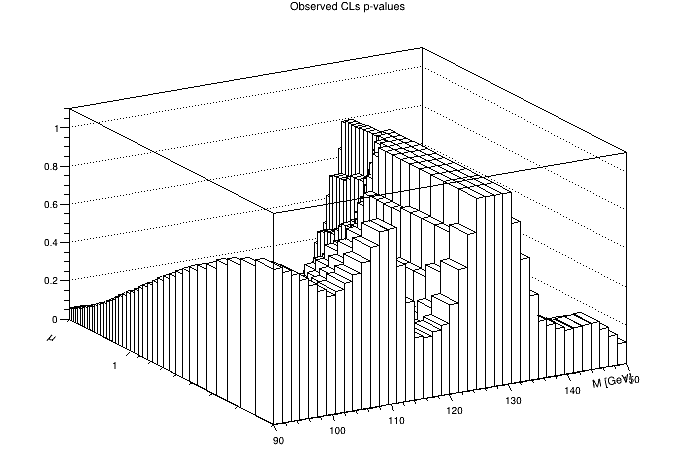

In [26]:
# now get p-value at every point in hypospace and plot contour where equals 0.05
full_obs_pvals = ROOT.TGraph2D();full_obs_pvals.SetTitle("Observed CLs p-values;M [GeV];\mu")
full_sigma_mu = ROOT.TGraph2D(); # use this to save all the sigma_mu values

for i in tqdm.tqdm(range(fullHypoSpace.GetN())):
    mass_var.setVal(fullHypoSpace.GetPointX(i));
    asimov_pll = pll(fullHypoSpace.GetPointY(i),*asimovData,False)
    sigma_mu = (mu_var.getVal()-mu_alt)/math.sqrt( asimov_pll )
    full_sigma_mu.AddPoint(fullHypoSpace.GetPointX(i),fullHypoSpace.GetPointY(i),sigma_mu)
    obs_pll = pll(fullHypoSpace.GetPointY(i),obsData,obsGlobs,True)
    
    p_null = asymptotic_pvalue_qmu(obs_pll, fullHypoSpace.GetPointY(i), fullHypoSpace.GetPointY(i), sigma_mu, 0)
    p_alt = asymptotic_pvalue_qmu(obs_pll, fullHypoSpace.GetPointY(i), 0, sigma_mu, 0)    
    full_obs_pvals.AddPoint(fullHypoSpace.GetPointX(i),fullHypoSpace.GetPointY(i),p_null/p_alt if p_alt>0 else (1 if p_null==p_alt else float('nan')))

# visualize our p-value graph
myPlot.cd()
full_obs_pvals.Draw("LEGO");
myPlot.Draw()

These p-value 2D graphs are used to extract the 95% CLs limits. This is done by finding the contours where the p-value equals 0.05.

Question: What piece of information would we need in order to compute an expected limit contour?

<span style="color:orange">**Task: Use the `asymptotic_expected_qmu` function provided in this lab to compute the p-value graphs for $-2\sigma$ to $2\sigma$:**</span>

In [27]:
help(asymptotic_expected_qmu)

Help on function asymptotic_expected_qmu in module __main__:

asymptotic_expected_qmu(pvalue, mu, mu_prime, sigma_mu, mu_min=-inf, mu_max=inf)
    Returns the qmu test statistic value corresponding to a given given p-value:
      pvalue : The pvalue that the returning test statistic would have under the true hypothesis (mu_prime)
      mu : The null hypothesis value of mu
      mu_prime : the true hypothesis mu value ( = mu for null hypothesis )
      sigma_mu : stdev of mu_hat under the true hypothesis (estimate as |mu - mu_prime|/sqrt(tmu(asimov_mu_prime))). Dependence on this parameter disappears for mu=mu_prime=0. 
      mu_min : min value of mu
      mu_max : max value of mu



In [28]:
# we will keep the collection of expected p-values in a dictionary of graphs
# a defaultdict is just a way to have a dictionary that will automatically create a new TGraph2D for us
# when we access a new key in the dictionary
from collections import defaultdict
full_exp_pvals = defaultdict(ROOT.TGraph2D)
for i in tqdm.tqdm(range(fullHypoSpace.GetN())):
    mass_var.setVal(fullHypoSpace.GetPointX(i));
    sigma_mu = full_sigma_mu.GetZ()[i] 
    
    def doExpected(nSigma):
        exp_pll = asymptotic_expected_qmu(ROOT.Math.normal_cdf(nSigma),fullHypoSpace.GetPointY(i), 0, sigma_mu,0)
        p_null = asymptotic_pvalue_qmu(exp_pll, fullHypoSpace.GetPointY(i), fullHypoSpace.GetPointY(i), sigma_mu, 0)
        p_alt = asymptotic_pvalue_qmu(exp_pll, fullHypoSpace.GetPointY(i), 0, sigma_mu, 0)    
        full_exp_pvals[nSigma].AddPoint(fullHypoSpace.GetPointX(i),fullHypoSpace.GetPointY(i),p_null/p_alt if p_alt>0 else (1 if p_null==p_alt else float('nan')))
        if nSigma > 0: doExpected(-nSigma)
    
    doExpected(0); doExpected(1); doExpected(2)

100%|██████████| 130/130 [00:00<00:00, 448.57it/s]


The following code block will do the contour finding from your p-value graphs and visualize the results for you.

Discussion point: Interpolating significances rather than p-values 

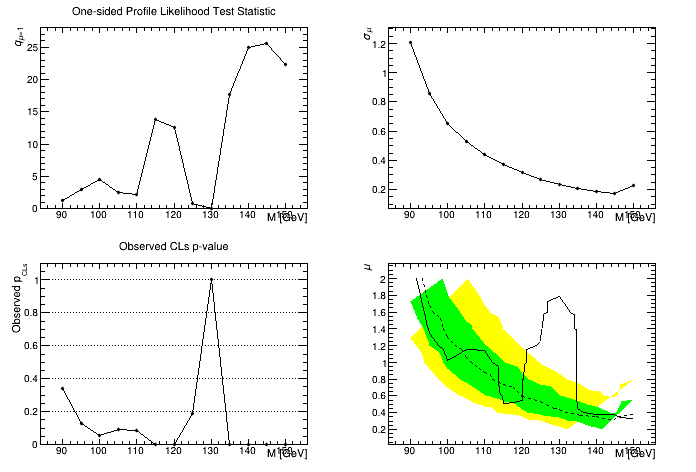

In [29]:
# This code is one way to estimate the pvalue=0.05 contours in your graphs. 
# It will also combine the +/-1sigma and +/-2sigma contours so that they can be visualized as 
# green and yellow 'bands' respectively

c.cd(4);
obs_limit = full_obs_pvals.GetContourList(0.05).At(0)
exp_limit = full_exp_pvals[0].GetContourList(0.05).At(0)
exp2_limit = full_exp_pvals[2].GetContourList(0.05).At(0)
expm2_limit = full_exp_pvals[-2].GetContourList(0.05).At(0)

# combine the two contours so can draw as a 'band'
exp2_limit.Sort();expm2_limit.Sort(ROOT.TGraph.CompareX,False)
l = ROOT.TList(); l.Add(expm2_limit)
exp2_limit.Merge(l)

exp1_limit = full_exp_pvals[1].GetContourList(0.05).At(0)
expm1_limit = full_exp_pvals[-1].GetContourList(0.05).At(0)

# likewise for 1sigma 'band'
exp1_limit.Sort();expm1_limit.Sort(ROOT.TGraph.CompareX,False)
l = ROOT.TList(); l.Add(expm1_limit)
exp1_limit.Merge(l)

exp2_limit.SetFillColor(ROOT.kYellow)
exp1_limit.SetFillColor(ROOT.kGreen)
exp_limit.SetLineStyle(2)
exp2_limit.SetTitle("95\% CLs Limit;M [GeV];\mu");
exp2_limit.Draw("AF")
exp1_limit.Draw("F")
exp_limit.Draw("L")
obs_limit.Draw("L")

c.Draw()

## Discovery Hypothesis Testing

This is a test of the SM (bkg only) hypothesis, using the "one sided capped-below" profile likelihood ratio as a test statistic, $q_0$, and the null hypothesis p-value. 

<span style="color:orange">**Task: Create an appropriate discovery hypothesis space:**</span> 

In [30]:
dHypoSpace = ROOT.TGraph()
dHypoSpace.SetTitle("Discovery Hypothesis Space;M [GeV];\mu")
mu_var.setVal(0)
mass_var.setVal(90)
while mass_var.getVal()<=150:
    dHypoSpace.AddPoint(mass_var.getVal(),mu_var.getVal())
    mass_var.setVal(mass_var.getVal()+5)

The asymptotic formula for the q0 test statistic is coded in the function `asymptotic_pvalue_q0` and there is also the function `asymptotic_expected_q0` for the value of $q_0$ corresponding to a particular p-value.

In [31]:
help(asymptotic_pvalue_q0)
help(asymptotic_expected_q0)

Help on function asymptotic_pvalue_q0 in module __main__:

asymptotic_pvalue_q0(q0, mu, mu_prime, sigma_mu, mu_min=-inf, mu_max=inf)
    q0 : the one-sided-negative test statistic value 
    mu : the null hypothesis mu value
    mu_prime : the true hypothesis mu value ( = mu for null hypothesis )
    sigma_mu : stdev of mu_hat under the true hypothesis (estimate as |mu - mu_prime|/sqrt(tmu(asimov_mu_prime))). Dependence on this parameter disappears for mu=mu_prime=0. 
    mu_min : min value of mu
    mu_max : max value of mu

Help on function asymptotic_expected_q0 in module __main__:

asymptotic_expected_q0(pvalue, mu, mu_prime, sigma_mu, mu_min=-inf, mu_max=inf)
    Returns the q0 test statistic value corresponding to a given given p-value:
      pvalue : The pvalue that the returning test statistic would have under the true hypothesis (mu_prime)
      mu : The null hypothesis value of mu
      mu_prime : the true hypothesis mu value ( = mu for null hypothesis )
      sigma_mu : stde

Note that in discovery tests it appears that the asymptotic p-value distribution doesn't depend on $\sigma_\mu$, so we can just use any value.

<span style="color:orange">**Task: Compute the null hypothesis p-values and the expected null hypothesis p-values assuming a true hypothesis of $\mu=1$:**</span> 

100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


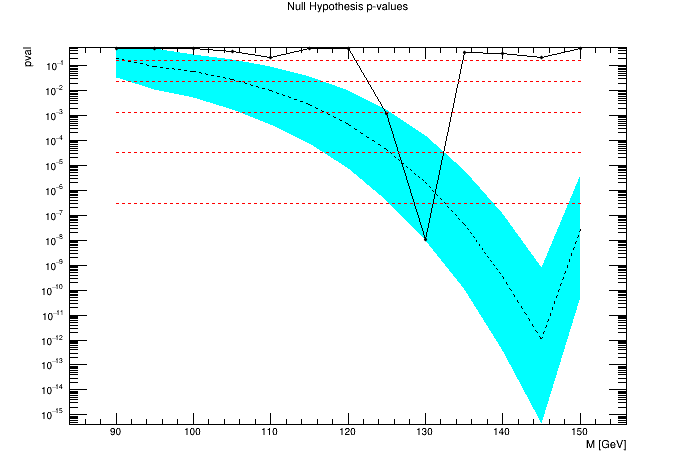

In [32]:
null_pvals = ROOT.TGraph()
null_pvals.SetTitle("Null Hypothesis P-Values;M [GeV];pval")
from collections import defaultdict
exp_pvals = defaultdict(ROOT.TGraph)

for i in tqdm.tqdm(range(dHypoSpace.GetN())):
    mass_var.setVal(dHypoSpace.GetPointX(i));
    mu_var.setVal(1); mu_var.setConstant(True)
    sigma_mu = 1./math.sqrt( pll(0,*generate(model,fit(model,obsData,obsGlobs),True),False) )
    
    obs_pll = pll(0,obsData,obsGlobs,True,False)
    
    p_null = asymptotic_pvalue_q0(obs_pll, dHypoSpace.GetPointY(i), dHypoSpace.GetPointY(i), sigma_mu, 0)
    null_pvals.AddPoint(dHypoSpace.GetPointX(i),p_null)
    
    def doExpected(nSigma):
        exp_pvals[nSigma].AddPoint(dHypoSpace.GetPointX(i),
            asymptotic_pvalue_q0(asymptotic_expected_q0(ROOT.Math.normal_cdf(nSigma),dHypoSpace.GetPointY(i), 1, sigma_mu,0), 
                             dHypoSpace.GetPointY(i), dHypoSpace.GetPointY(i), sigma_mu, 0))
        if nSigma > 0: doExpected(-nSigma)
        
    doExpected(0);doExpected(1)
        
myPlot.cd().SetLogy()

exp_pvals[-1].Sort(ROOT.TGraph.CompareX,False)
l = ROOT.TList(); l.Add(exp_pvals[-1])
exp_pvals[1].Merge(l)

exp_pvals[1].SetFillColor(ROOT.kCyan)
exp_pvals[1].SetTitle("Null Hypothesis p-values;M [GeV];pval")
exp_pvals[1].Draw("AF")

exp_pvals[0].SetLineStyle(2)
exp_pvals[0].Draw("L")
null_pvals.Draw("LP")
l = ROOT.TLine(); l.SetLineStyle(2); l.SetLineColor(ROOT.kRed)
def drawSigmaLine(nSigma):
    l.DrawLine(dHypoSpace.GetPointX(0),ROOT.Math.normal_cdf_c(nSigma),dHypoSpace.GetPointX(dHypoSpace.GetN()-1),ROOT.Math.normal_cdf_c(nSigma))
for i in range(1,6): drawSigmaLine(i)
myPlot.Draw()

## Measurement

Now that you may have discovered something we proceed to measurements. To get a measurement of a parameter with an assigned error we need to scan the profile likelihood ratio...

<span style="color:orange">**Task: Scan the PLR of the mass parameter...**</span> 

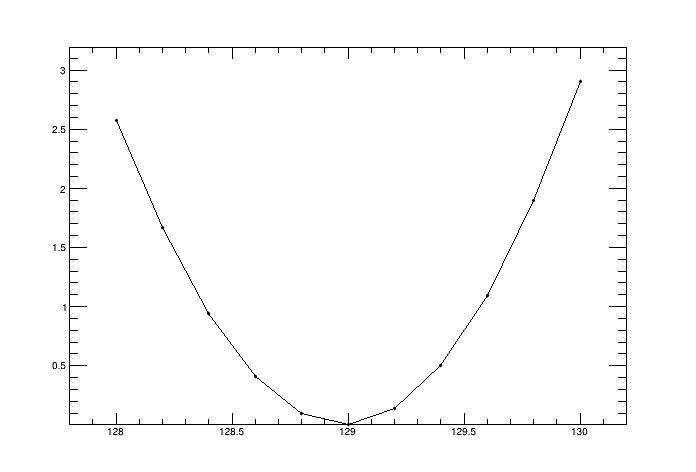

In [34]:
pll_mass = ROOT.TGraph()

mu_var.setConstant(False) # question: difference between floating mu vs keeping it constant
mu_var.setVal(1)
mass_var.setConstant(False)
mass_var.setVal(135)
ufit = fit(model,obsData,obsGlobs)

mass_var.setConstant(True); mass_var.setVal(90)
while mass_var.getVal()<=150:
    fr = fit(model,obsData,obsGlobs)
    pll = 2.*(fr.minNll() - ufit.minNll())
    if pll < 3:
        pll_mass.AddPoint(mass_var.getVal(),pll)
    mass_var.setVal(mass_var.getVal()+(0.2 if pll<3 else 1))

myPlot.cd()
ROOT.gPad.SetLogy(False)
pll_mass.Draw("ALP")
ROOT.gPad.Draw()

<span style="color:orange">**Task: Compare and contrast the error from the hessian (in the unconditional fit) to the *minos error*...**</span> 

In [35]:

down = None
up = None
x = pll_mass.GetPointX(0)
while up is None:
    if not down and pll_mass.Eval(x)<1: down = x
    if down and pll_mass.Eval(x)>1: up = x
    x += 0.01
        
ufit.Print()

up -= ufit.floatParsFinal().find("sig_mass").getVal()
down -= ufit.floatParsFinal().find("sig_mass").getVal()

print("up=",up,"down=",down)

up= 0.588232303047306 down= -0.5917676969516208

  RooFitResult: minimized FCN value: -8005.83, estimated distance to minimum: 4.97571e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
            alpha_lumi    5.0334e+00 +/-  8.47e-02
                    mu    1.3645e+00 +/-  2.87e-01
              sig_mass    1.2898e+02 +/-  5.91e-01



Finally, lets compute the "impact" of one parameter on another.

<span style="color:orange">**Task: Complete the function below that computes the impact of one parameter with another...**</span> 

In [36]:
# just do the "post-fit" impact here
def impact(ufit,poiName,npName):
    np_nom = ufit.floatParsFinal().find(npName).getVal()
    np_err = ufit.floatParsFinal().find(npName).getError()
    
    np = model.getVariables()[npName]
    
    # ensure all parameters of the ufit are floating
    model.getVariables().selectCommon(ufit.floatParsFinal()).setAttribAll("Constant",False)
    
    np.setConstant()
    np.setVal(np_nom + np_err)
    upfit = fit(model,obsData,obsGlobs)
    np.setVal(np_nom - np_err)
    downfit = fit(model,obsData,obsGlobs)
    
    poi_nom = ufit.floatParsFinal().find(poiName).getVal()
    
    return (upfit.floatParsFinal().find(poiName).getVal() - poi_nom) , (downfit.floatParsFinal().find(poiName).getVal() - poi_nom)

print("sig_mass:",impact(ufit,"mu","sig_mass"))
print("alpha_lumi:",impact(ufit,"mu","alpha_lumi"))

sig_mass: (-0.030297413152774455, -0.018191855394755763)
alpha_lumi: (-0.06528838479509802, 0.07088016645852568)


Question: How is impact related to covariance?

In [ ]:
ufit.covarianceMatrix().Print()